# 경제 분석 및 예측과 데이터 지능 실습4: Dynamic Factor Model

OECD데이터를 활용해 VAR 분석을 실습합니다. Statsmodels을 주로 다루고, 실제 데이터에 적용해 봅니다.

실습 전 터미널에 아래 코드를 실행하여 환경설정을 맞춰줍니다.

conda env update -n forecasting_lecture -f environment.yml --prune

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
# 1. Load & preprocess data
# --------------------------
df = pd.read_csv('../datasets/querterly_oecd_account_data.csv',
                 parse_dates=['date'])
df['date'] = df['date'].dt.to_period('Q')

vars_to_use = ['Y', 'C', 'G', 'I', 'EX', 'IM']

In [5]:
df

,country,date,Y,C,G,I,EX,IM
0,CAN,1990Q1,1015714.7,518707.4,271355.6,223461.1,207736.8,200021.9
1,DEU,1990Q1,3220806.5,1811014.8,569128.8,725261.2,527153.8,489620.3
2,FRA,1990Q1,2244890.8,1170205.4,554966.9,517196.6,352329.9,353194.4
3,GBR,1990Q1,2038060.5,1141647.3,450827.1,404835.9,345478.9,331416.2
4,IRL,1990Q1,99243.7,47489.0,21623.8,23005.3,29526.0,33508.4
...,...,...,...,...,...,...,...,...
1510,ITA,2024Q4,3058928.9,1722741.8,577189.2,687706.9,947135.2,851761.5
1511,JPN,2024Q4,5685249.7,3019732.3,1192953.7,1395443.7,1041559.3,962723.9
1512,KOR,2024Q4,2761625.7,1325159.4,482440.0,796442.2,1105866.4,947051.6
1513,MEX,2024Q4,2825213.5,1966980.1,314718.3,699365.0,1144131.3,1253890.4


### 분기별 변화율을 계산하고 연도별 변화율로 annualize 합니다.

pct_change : $\frac{x_t - x_{t-1}}{x_{t-1}}$

In [6]:
# compute annualized q-to-q growth by country
df_growth = (
    df.set_index(['date','country'])[vars_to_use]
      .sort_index()
      .groupby('country')
      .pct_change()   # quarter-to-quarter % change
      .mul(400)       # annualize
      .dropna()
      .reset_index()
)

In [7]:
df_growth

,date,country,Y,C,G,I,EX,IM
0,1990Q2,CAN,-1.604899,-4.397470,-4.739021,-9.666649,14.559000,0.972094
1,1990Q2,DEU,1.966650,4.530985,4.203548,-1.872153,-12.497074,4.329396
2,1990Q2,FRA,2.149022,2.356373,1.528379,1.493049,-10.373233,2.894383
3,1990Q2,GBR,2.691736,4.575984,1.491037,-5.702558,-0.884917,-1.072971
4,1990Q2,IRL,8.237097,-0.163406,6.587186,11.475616,7.192305,1.866995
...,...,...,...,...,...,...,...,...
1499,2024Q4,ITA,0.542257,0.782655,0.723357,6.426822,-0.686788,-1.514761
1500,2024Q4,JPN,2.224569,0.126873,1.603582,0.851373,4.068308,-8.566318
1501,2024Q4,KOR,0.264860,0.957007,2.823791,-6.445716,3.100825,0.482371
1502,2024Q4,MEX,-2.527285,-5.636310,-0.384355,-6.206416,14.533305,4.841508


In [8]:
# pivot to a wide panel (MultiIndex columns)
panel = df_growth.pivot(
    index='date',
    columns='country',
    values=vars_to_use
)

# fill any gaps (forward/backward) rather than drop
panel = panel.interpolate().ffill().bfill()

# drop any series that ended up constant
panel = panel.loc[:, panel.std() > 0]

# NOW flatten the MultiIndex into single strings: "Y_CAN", "C_DEU", etc.
panel.columns = [f"{var}_{ctry}" for var, ctry in panel.columns]

# standardize (mean=0, std=1)
endog = (panel - panel.mean()) / panel.std()

In [9]:
panel

,Y_CAN,Y_DEU,Y_FRA,Y_GBR,Y_IND,Y_IRL,Y_ITA,Y_JPN,Y_KOR,Y_MEX,...,IM_DEU,IM_FRA,IM_GBR,IM_IND,IM_IRL,IM_ITA,IM_JPN,IM_KOR,IM_MEX,IM_USA
date,,,,,,,,,,,,,,,,,,,,,
1990Q2,-1.604899,1.966650,2.149022,2.691736,1.955917,8.237097,1.219137,12.615878,9.017118,8.679217,...,4.329396,2.894383,-1.072971,76.635117,1.866995,8.595439,4.303179,10.942332,0.887507,-0.670707
1990Q3,-2.866674,8.423731,2.599187,-4.391767,1.955917,5.030833,0.641380,6.706963,14.174941,5.456557,...,30.772830,1.781925,-6.765434,76.635117,0.577458,-1.925537,-4.798272,12.815959,58.360235,-1.615312
1990Q4,-3.561647,7.041689,-0.192075,-2.028692,1.955917,1.818620,-2.598346,-0.759920,7.626647,5.083811,...,20.966204,-2.419467,-6.869520,76.635117,0.246786,27.492700,21.939681,18.652478,11.311060,-10.727253
1991Q1,-5.754445,10.874742,1.052461,-1.970087,1.955917,0.099391,4.000091,3.485273,14.634599,1.102419,...,6.329821,13.562836,-13.293236,76.635117,1.106296,-21.662423,-23.565770,24.304653,-12.891911,-4.558196
1991Q2,1.919836,-1.751893,1.477162,-0.462038,1.955917,0.090439,2.168677,4.745645,6.817302,6.120906,...,2.665105,0.000654,1.763537,76.635117,3.007021,12.196338,0.305165,19.347305,29.685205,7.109352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023Q4,0.701022,-1.485721,1.943732,-0.829848,7.170527,-8.909823,0.803995,0.085450,1.820070,1.462541,...,-8.149187,-7.252476,3.851561,-30.851565,52.081818,-4.351215,12.361432,6.579925,0.213147,4.149710
2024Q1,1.817139,0.946324,0.295674,3.623950,6.755978,6.380011,1.362850,-2.071618,5.200438,-0.127350,...,4.397360,-0.690182,-1.627130,-3.278002,-25.507611,-0.290350,-11.090645,-1.701894,7.883325,6.001667
2024Q2,2.741968,-1.182501,1.036824,1.831079,4.607702,-1.411571,0.303030,3.208850,-0.910578,1.149389,...,4.915888,0.984152,21.951850,18.718829,18.670763,0.635443,12.059576,6.287616,2.062720,7.360122


In [10]:
# 2. Specify & fit DynamicFactorMQ
# ---------------------------------
k_factors  = 3   # number of common factors
factor_ord = 4   # VAR order for factor dynamics

model = sm.tsa.DynamicFactorMQ(
    endog,
    factors=k_factors,
    factor_orders=factor_ord,
    idiosyncratic_ar1=True,
    standardize=False
)

In [12]:
results = model.fit(disp=False)
print(results.summary())

                               Dynamic Factor Results                              
Dep. Variable:        "Y_CAN", and 65 more   No. Observations:                  139
Model:                Dynamic Factor Model   Log Likelihood               -8477.334
                   + 3 factors in 3 blocks   AIC                          17644.668
                     + AR(1) idiosyncratic   BIC                          18657.061
Date:                     Sat, 17 May 2025   HQIC                         18056.077
Time:                             16:38:45   EM Iterations                      122
Sample:                         06-30-1990                                         
                              - 12-31-2024                                         
Covariance Type:              Not computed                                         
                                Observation equation:                                
Factor loadings:          0          1          2    idiosyncratic: AR(1) 

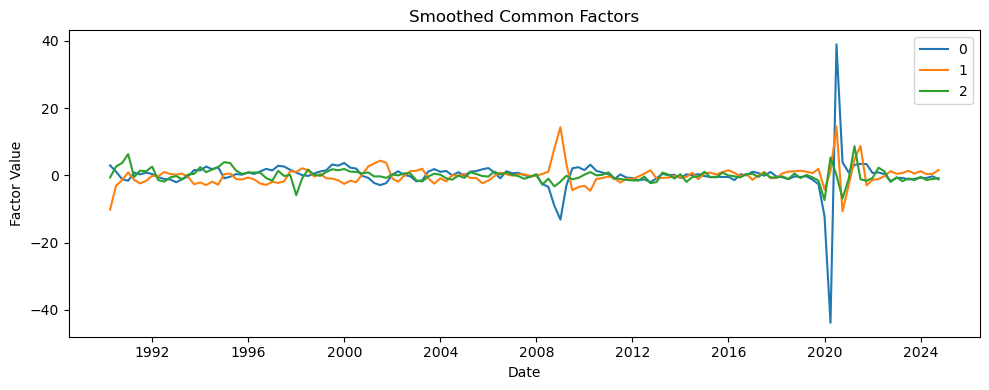

In [13]:
# 3. Extract & plot smoothed factors
# -----------------------------------
factors = results.factors.smoothed
plt.figure(figsize=(10, 4))
for col in factors.columns:
    plt.plot(factors.index.to_timestamp(), factors[col], label=col)
plt.title("Smoothed Common Factors")
plt.xlabel("Date")
plt.ylabel("Factor Value")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# 4. Forecasting
# --------------
fc_res  = results.get_forecast(steps=16)
fc_mean = fc_res.predicted_mean
fc_ci   = fc_res.conf_int()

# rename "lower Y_CAN" → "Y_CAN_lower" etc.
fc_ci.columns = [
    f"{name.split(' ',1)[1]}_{name.split(' ',1)[0]}"
    for name in fc_ci.columns
]

In [15]:
endog.columns

Index(['Y_CAN', 'Y_DEU', 'Y_FRA', 'Y_GBR', 'Y_IND', 'Y_IRL', 'Y_ITA', 'Y_JPN',
       'Y_KOR', 'Y_MEX', 'Y_USA', 'C_CAN', 'C_DEU', 'C_FRA', 'C_GBR', 'C_IND',
       'C_IRL', 'C_ITA', 'C_JPN', 'C_KOR', 'C_MEX', 'C_USA', 'G_CAN', 'G_DEU',
       'G_FRA', 'G_GBR', 'G_IND', 'G_IRL', 'G_ITA', 'G_JPN', 'G_KOR', 'G_MEX',
       'G_USA', 'I_CAN', 'I_DEU', 'I_FRA', 'I_GBR', 'I_IND', 'I_IRL', 'I_ITA',
       'I_JPN', 'I_KOR', 'I_MEX', 'I_USA', 'EX_CAN', 'EX_DEU', 'EX_FRA',
       'EX_GBR', 'EX_IND', 'EX_IRL', 'EX_ITA', 'EX_JPN', 'EX_KOR', 'EX_MEX',
       'EX_USA', 'IM_CAN', 'IM_DEU', 'IM_FRA', 'IM_GBR', 'IM_IND', 'IM_IRL',
       'IM_ITA', 'IM_JPN', 'IM_KOR', 'IM_MEX', 'IM_USA'],
      dtype='object')

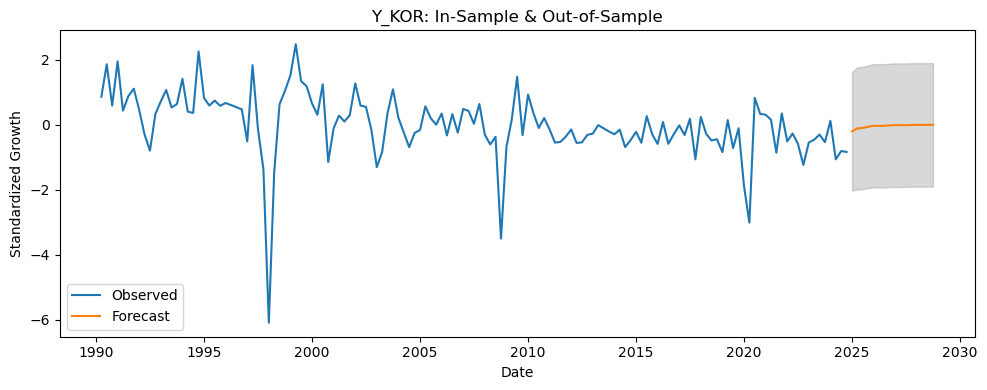

In [35]:
series = "Y_KOR"
plt.figure(figsize=(10,4))
plt.plot(endog.index.to_timestamp(), endog[series], label="Observed")
plt.plot(fc_mean.index.to_timestamp(), fc_mean[series], label="Forecast")
plt.fill_between(
    fc_ci.index.to_timestamp(),
    fc_ci[f"{series}_lower"],
    fc_ci[f"{series}_upper"],
    color='gray', alpha=0.3
)
plt.title(f"{series}: In-Sample & Out-of-Sample")
plt.xlabel("Date")
plt.ylabel("Standardized Growth")
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
# 5. Diagnostics
# --------------
# Ljung–Box p-values per series
lb_pvals = {
    col: sm.stats.acorr_ljungbox(results.resid[col], lags=[10], return_df=True)
               ['lb_pvalue'].iloc[0]
    for col in results.resid.columns
}
lb_df = pd.DataFrame.from_dict(
    lb_pvals, orient='index',
    columns=['Ljung-Box p-value (lag=10)']
)
print("\nLjung-Box test:\n", lb_df)


Ljung-Box test:
         Ljung-Box p-value (lag=10)
Y_CAN                     0.949511
Y_DEU                     0.662279
Y_FRA                     0.898482
Y_GBR                     0.591868
Y_IND                     0.001418
...                            ...
IM_ITA                    0.004023
IM_JPN                    0.227427
IM_KOR                    0.101877
IM_MEX                    0.703488
IM_USA                    0.572683

[66 rows x 1 columns]


In [37]:
results.get_coefficients_of_determination()

,0,1,2
Y_CAN,0.865622,0.001769,0.033460
Y_DEU,0.762435,0.000193,0.032595
Y_FRA,0.915685,0.065917,0.001384
Y_GBR,0.886840,0.035227,0.001229
Y_IND,0.708788,0.035325,0.112756
...,...,...,...
IM_ITA,0.625978,0.015222,0.002079
IM_JPN,0.008524,0.325954,0.043797
IM_KOR,0.075360,0.086540,0.176474
IM_MEX,0.479819,0.103453,0.013823


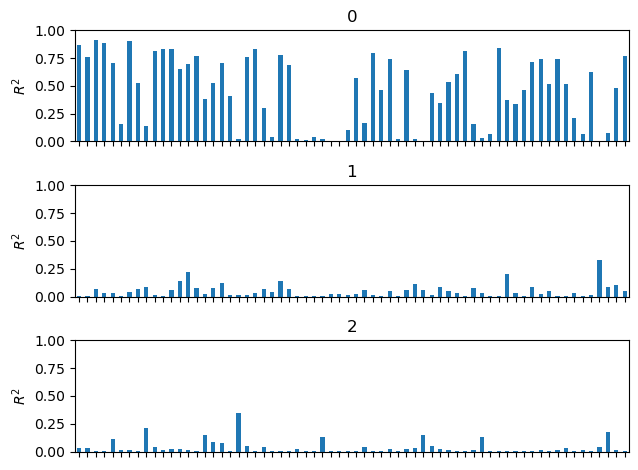

In [38]:
results.plot_coefficients_of_determination()
plt.tight_layout()
plt.show()